#**Remote Work and Mental Health Analysis**
Muhammad Arif Irfan bin Ibrahim
<br/>
m.a.irfan.ibrahim@gmail.com

Source:
Impact_of_Remote_Work_on_Mental_Health
<br/>
https://www.kaggle.com/datasets/waqi786/remote-work-and-mental-health

##**Business Case**


The success of both companies can be reflected by the work productivity and the work satisfaction. This dataset explores various areas of data regarding the remote working experience. From this dataset, this study aims to discover the factors that can lead for better managerial decisions to improve the work productivity as well as the work satisfaction. This in turn hope to better the life of both the employers and the employees.


Though the source file is to study the effects of remote work towards mental health, the dataset contains the potential data to solve other issues. This study aims to do just that.

##**Data Science Questions**

|No. |Question | Variable |
|:---:|:--------|:---------|
| 1|Is there a significant difference in Stress_Level between employees working remotely, hybrid, or onsite?         |     Stress_Level, Work_Location    |
| 2|Does Gender have a statistically significant impact on Satisfaction_with_Remote_Work?         |     Gender, Satisfaction_with_Remote_Work   |
| 3|Is Social_Isolation_Rating associated with reporting a Mental_Health_Condition?       |     Social_Isolation_Rating, Mental_Health_Condition   |
| 4| What factors (Age, Job_Role, Industry, Work_Location) are most strongly associated with higher Stress_Level?         |     Age, Job_Role, Industry, Work_Location, Stress_Level    |
| 5| Can Social_Isolation_Rating, Age, and Job_Role predict the likelihood of an employee reporting a Mental_Health_Condition?        |     Social_Isolation_Rating, Age, Job_Role, Mental_Health_Condition     |
| 6|What interventions could improve Satisfaction_with_Remote_Work for specific Job_Roles and Industries?       |     Job_Role, Industry, Satisfaction_with_Remote_Work     |
| 7|Which factors (Gender, Age, Industry, and Job_Role) are predictive of an employee’s Stress_Level?        |     Gender, Age, Industry, Job_Role, Stress_Level    |
| 8|Does Satisfaction_with_Remote_Work impact Stress_Level or Social_Isolation_Rating, and does this differ by Work_Location?      |     Satisfaction_with_Remote_Work, Stress_Level, Social_Isolation_Rating, Work_Location   |

***
***
## **Loading Dataset, Libraries, and Initalise Pyspark**
1. import necessary libraries
2. build pyspark
3. import dataset
4. display head
5. show data types

In [ ]:
# import necessary libraries
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import NumericType
from pyspark.sql.functions import when, col
from pyspark.sql.functions import min, max
from pyspark.sql import functions as F

from scipy.stats import chi2_contingency
import scipy.stats as stats

import networkx as nx

In [ ]:
# build pyspark
spark = SparkSession.builder.appName('assignment1').getOrCreate()

# import dataset
drive.mount('/content/drive')
df = spark.read.csv('/content/drive/MyDrive/Impact_of_Remote_Work_on_Mental_Health.csv', header=True, inferSchema=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# display head
df.show(5, truncate = False)

+-----------+---+----------+-----------------+----------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------------------------------+-----------------+-------------+-------------+
|Employee_ID|Age|Gender    |Job_Role         |Industry  |Years_of_Experience|Work_Location|Hours_Worked_Per_Week|Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Stress_Level|Mental_Health_Condition|Access_to_Mental_Health_Resources|Productivity_Change|Social_Isolation_Rating|Satisfaction_with_Remote_Work|Company_Support_for_Remote_Work|Physical_Activity|Sleep_Quality|Region       |
+-----------+---+----------+-----------------+----------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+--------------------

In [ ]:
# show data types
df.printSchema()

root
 |-- Employee_ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Job_Role: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Years_of_Experience: integer (nullable = true)
 |-- Work_Location: string (nullable = true)
 |-- Hours_Worked_Per_Week: integer (nullable = true)
 |-- Number_of_Virtual_Meetings: integer (nullable = true)
 |-- Work_Life_Balance_Rating: integer (nullable = true)
 |-- Stress_Level: string (nullable = true)
 |-- Mental_Health_Condition: string (nullable = true)
 |-- Access_to_Mental_Health_Resources: string (nullable = true)
 |-- Productivity_Change: string (nullable = true)
 |-- Social_Isolation_Rating: integer (nullable = true)
 |-- Satisfaction_with_Remote_Work: string (nullable = true)
 |-- Company_Support_for_Remote_Work: integer (nullable = true)
 |-- Physical_Activity: string (nullable = true)
 |-- Sleep_Quality: string (nullable = true)
 |-- Region: string (nullable = true)



***
***
## **Data Cleaning and Preparation**

### **Dropping Unecessary Columns**
1. get column names
2. drop `Employee_ID` column
3. get number of row and column

In [ ]:
# get column names
df.columns

['Employee_ID',
 'Age',
 'Gender',
 'Job_Role',
 'Industry',
 'Years_of_Experience',
 'Work_Location',
 'Hours_Worked_Per_Week',
 'Number_of_Virtual_Meetings',
 'Work_Life_Balance_Rating',
 'Stress_Level',
 'Mental_Health_Condition',
 'Access_to_Mental_Health_Resources',
 'Productivity_Change',
 'Social_Isolation_Rating',
 'Satisfaction_with_Remote_Work',
 'Company_Support_for_Remote_Work',
 'Physical_Activity',
 'Sleep_Quality',
 'Region']

Since the `Employee_ID` would not bring any known value other than act as a reference for specific employees, it can be dropped from the dataset.

In [ ]:
# drop `Employee_ID` column
df = df.drop("Employee_ID")
df.show(10)

+---+-----------------+-----------------+-------------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------------------------------+-----------------+-------------+-------------+
|Age|           Gender|         Job_Role|     Industry|Years_of_Experience|Work_Location|Hours_Worked_Per_Week|Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Stress_Level|Mental_Health_Condition|Access_to_Mental_Health_Resources|Productivity_Change|Social_Isolation_Rating|Satisfaction_with_Remote_Work|Company_Support_for_Remote_Work|Physical_Activity|Sleep_Quality|       Region|
+---+-----------------+-----------------+-------------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+--------------------------

In [ ]:
# get number of row and column
row = df.count()
col = len(df.columns)

print(f'Rows: {row}')
print(f'Columns: {col}')

Rows: 5000
Columns: 19


***
### **Handling Missing Data**
1. find missing data

In [ ]:
# find missing data
from pyspark.sql.functions import col, sum as _sum, when, isnan

missing_data_count = df.select([
    _sum(when(col(c).isNull() | isnan(c), 1).otherwise(0)).alias(c)
    for c in df.columns
])

missing_data_count.show()

+---+------+--------+--------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------------------------------+-----------------+-------------+------+
|Age|Gender|Job_Role|Industry|Years_of_Experience|Work_Location|Hours_Worked_Per_Week|Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Stress_Level|Mental_Health_Condition|Access_to_Mental_Health_Resources|Productivity_Change|Social_Isolation_Rating|Satisfaction_with_Remote_Work|Company_Support_for_Remote_Work|Physical_Activity|Sleep_Quality|Region|
+---+------+--------+--------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------

***
### **Handling Duplicates**
1. find duplicates

In [ ]:
# find duplicates
duplicates = (df.groupBy(df.columns).count().filter(col('count') > 1))
duplicates.show()

+---+------+--------+--------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------------------------------+-----------------+-------------+------+-----+
|Age|Gender|Job_Role|Industry|Years_of_Experience|Work_Location|Hours_Worked_Per_Week|Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Stress_Level|Mental_Health_Condition|Access_to_Mental_Health_Resources|Productivity_Change|Social_Isolation_Rating|Satisfaction_with_Remote_Work|Company_Support_for_Remote_Work|Physical_Activity|Sleep_Quality|Region|count|
+---+------+--------+--------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-------------------------

***
### **Standardizing Data Format**
1. string columns
2. numeric columns
3. numeric rating columns
4. numeric range columns

#### **String Columns**
1. get string columns
2. get unique values in string columns

In [ ]:
# get string columns
string_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
string_columns

['Gender',
 'Job_Role',
 'Industry',
 'Work_Location',
 'Stress_Level',
 'Mental_Health_Condition',
 'Access_to_Mental_Health_Resources',
 'Productivity_Change',
 'Satisfaction_with_Remote_Work',
 'Physical_Activity',
 'Sleep_Quality',
 'Region']

In [ ]:
# get unique values in string columns
for column in string_columns:
    print(f"Unique values in column '{column}':")
    df.select(column).distinct().show()

Unique values in column 'Gender':
+-----------------+
|           Gender|
+-----------------+
|Prefer not to say|
|           Female|
|       Non-binary|
|             Male|
+-----------------+

Unique values in column 'Job_Role':
+-----------------+
|         Job_Role|
+-----------------+
|            Sales|
|  Project Manager|
|               HR|
|         Designer|
|   Data Scientist|
|        Marketing|
|Software Engineer|
+-----------------+

Unique values in column 'Industry':
+-------------+
|     Industry|
+-------------+
|    Education|
|   Healthcare|
|      Finance|
|   Consulting|
|           IT|
|       Retail|
|Manufacturing|
+-------------+

Unique values in column 'Work_Location':
+-------------+
|Work_Location|
+-------------+
|       Remote|
|       Onsite|
|       Hybrid|
+-------------+

Unique values in column 'Stress_Level':
+------------+
|Stress_Level|
+------------+
|        High|
|         Low|
|      Medium|
+------------+

Unique values in column 'Mental_Hea

#### **Numeric Columns**
1. get numeric columns
2. make sure all columns are included (including string columns)
3. get unique values in rating column

In [ ]:
# get numeric columns
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]
df.select(numeric_columns).show()

+---+-------------------+---------------------+--------------------------+------------------------+-----------------------+-------------------------------+
|Age|Years_of_Experience|Hours_Worked_Per_Week|Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Social_Isolation_Rating|Company_Support_for_Remote_Work|
+---+-------------------+---------------------+--------------------------+------------------------+-----------------------+-------------------------------+
| 32|                 13|                   47|                         7|                       2|                      1|                              1|
| 40|                  3|                   52|                         4|                       1|                      3|                              2|
| 59|                 22|                   46|                        11|                       5|                      4|                              5|
| 27|                 20|                   32|                 

Now, to make sure that all of the columns have been accounted for, the total number of columns can be displayed.

In [ ]:
# make sure all columns are included (including string columns)
string_columns_col = len(string_columns)
numeric_columns_col = len(numeric_columns)

print(f'Number of columns in string columns: {string_columns_col}')
print(f'Number of columns in numeric columns: {numeric_columns_col}')
print(f'Toal number of columns: {numeric_columns_col + string_columns_col}')

col = len(df.columns)
print(f'Actual number of columns: {col}')

Number of columns in string columns: 12
Number of columns in numeric columns: 7
Toal number of columns: 19
Actual number of columns: 19


#### **Numeric Rating Columns**
1. get unique values in rating column
2. convert rating columns (`Work_Life_Balance_Rating`, `Social_Isolation_Rating`, `Company_Support_for_Remote_Work`) into a string column
3. get updated unique values in the column

In [ ]:
# get unique values in rating column
numeric_rating_columns = ['Work_Life_Balance_Rating', 'Social_Isolation_Rating', 'Company_Support_for_Remote_Work']

for column in numeric_rating_columns:
    print(f"Unique values in column '{column}':")
    df.select(column).distinct().orderBy(column).show()

Unique values in column 'Work_Life_Balance_Rating':
+------------------------+
|Work_Life_Balance_Rating|
+------------------------+
|                       1|
|                       2|
|                       3|
|                       4|
|                       5|
+------------------------+

Unique values in column 'Social_Isolation_Rating':
+-----------------------+
|Social_Isolation_Rating|
+-----------------------+
|                      1|
|                      2|
|                      3|
|                      4|
|                      5|
+-----------------------+

Unique values in column 'Company_Support_for_Remote_Work':
+-------------------------------+
|Company_Support_for_Remote_Work|
+-------------------------------+
|                              1|
|                              2|
|                              3|
|                              4|
|                              5|
+-------------------------------+



In [ ]:
# convert rating columns (`Work_Life_Balance_Rating`, `Social_Isolation_Rating`, `Company_Support_for_Remote_Work`) into a string column
from pyspark.sql.functions import when, col

rating_mapping = {
    1: "Very Poor",
    2: "Poor",
    3: "Average",
    4: "Good",
    5: "Excellent"
}

for column in numeric_rating_columns:
    if column in df.columns:
        df = df.withColumn(
            column,
            when(col(column) == 1, "Very Poor")
            .when(col(column) == 2, "Poor")
            .when(col(column) == 3, "Average")
            .when(col(column) == 4, "Good")
            .when(col(column) == 5, "Excellent")
        )

df.show(10)

+---+-----------------+-----------------+-------------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------------------------------+-----------------+-------------+-------------+
|Age|           Gender|         Job_Role|     Industry|Years_of_Experience|Work_Location|Hours_Worked_Per_Week|Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Stress_Level|Mental_Health_Condition|Access_to_Mental_Health_Resources|Productivity_Change|Social_Isolation_Rating|Satisfaction_with_Remote_Work|Company_Support_for_Remote_Work|Physical_Activity|Sleep_Quality|       Region|
+---+-----------------+-----------------+-------------+-------------------+-------------+---------------------+--------------------------+------------------------+------------+-----------------------+--------------------------

In [ ]:
# get updated unique values in the column
for column in numeric_rating_columns:
    print(f"Unique values in column '{column}':")
    df.select(column).distinct().orderBy(column).show()

Unique values in column 'Work_Life_Balance_Rating':
+------------------------+
|Work_Life_Balance_Rating|
+------------------------+
|                 Average|
|               Excellent|
|                    Good|
|                    Poor|
|               Very Poor|
+------------------------+

Unique values in column 'Social_Isolation_Rating':
+-----------------------+
|Social_Isolation_Rating|
+-----------------------+
|                Average|
|              Excellent|
|                   Good|
|                   Poor|
|              Very Poor|
+-----------------------+

Unique values in column 'Company_Support_for_Remote_Work':
+-------------------------------+
|Company_Support_for_Remote_Work|
+-------------------------------+
|                        Average|
|                      Excellent|
|                           Good|
|                           Poor|
|                      Very Poor|
+-------------------------------+



#### **Numeric Range Columns**
1. get range columns
2. convert range columns (`Age`, `Years_of_Experience`, `Hours_Worked_Per_Week`, `Number_of_Virtual_Meetings`) into a string column
3. review columns

In [ ]:
# get range columns
numeric_range_columns = ['Age', 'Years_of_Experience', 'Hours_Worked_Per_Week', 'Number_of_Virtual_Meetings']

for col_name in numeric_range_columns:
    print(f"Min-Max for: {col_name}")
    stats_df = df.select(
        min(col_name).alias(f"min_{col_name}"),
        max(col_name).alias(f"max_{col_name}")
    )

    stats_df.show()

Min-Max for: Age
+-------+-------+
|min_Age|max_Age|
+-------+-------+
|     22|     60|
+-------+-------+

Min-Max for: Years_of_Experience
+-----------------------+-----------------------+
|min_Years_of_Experience|max_Years_of_Experience|
+-----------------------+-----------------------+
|                      1|                     35|
+-----------------------+-----------------------+

Min-Max for: Hours_Worked_Per_Week
+-------------------------+-------------------------+
|min_Hours_Worked_Per_Week|max_Hours_Worked_Per_Week|
+-------------------------+-------------------------+
|                       20|                       60|
+-------------------------+-------------------------+

Min-Max for: Number_of_Virtual_Meetings
+------------------------------+------------------------------+
|min_Number_of_Virtual_Meetings|max_Number_of_Virtual_Meetings|
+------------------------------+------------------------------+
|                             0|                            15|
+-----

In [ ]:
# convert range columns (`Age`, `Years_of_Experience`, `Hours_Worked_Per_Week`, `Number_of_Virtual_Meetings`) into a string column
df = df.withColumn(
    'Years_of_Experience',
    when(col('Years_of_Experience') <= 2, 'Entry Level (0-2 years)')
    .when((col('Years_of_Experience') >= 3) & (col('Years_of_Experience') <= 5), 'Junior (3-5 years)')
    .when((col('Years_of_Experience') >= 6) & (col('Years_of_Experience') <= 10), 'Mid-Level (6-10 years)')
    .when((col('Years_of_Experience') >= 11) & (col('Years_of_Experience') <= 20), 'Senior (11-20 years)')
    .otherwise('Expert (>20 years)')
).withColumn(
    'Hours_Worked_Per_Week',
    when(col('Hours_Worked_Per_Week') <= 20, 'Part-Time (<20 hours)')
    .when((col('Hours_Worked_Per_Week') >= 21) & (col('Hours_Worked_Per_Week') <= 39), 'Reduced Hours (21-39 hours)')
    .when((col('Hours_Worked_Per_Week') >= 40) & (col('Hours_Worked_Per_Week') <= 50), 'Full-Time (40-50 hours)')
    .otherwise('Overworked (>50 hours)')
).withColumn(
    'Number_of_Virtual_Meetings',
    when(col('Number_of_Virtual_Meetings') <= 2, 'Minimal (<3 meetings)')
    .when((col('Number_of_Virtual_Meetings') >= 3) & (col('Number_of_Virtual_Meetings') <= 5), 'Moderate (3-5 meetings)')
    .when((col('Number_of_Virtual_Meetings') >= 6) & (col('Number_of_Virtual_Meetings') <= 10), 'High (6-10 meetings)')
    .otherwise('Excessive (>10 meetings)')
).withColumn(
    'Age',
    when(col('Age') <= 18, 'Child (<19)')
    .when((col('Age') >= 19) & (col('Age') <= 25), 'Young Adult (19-25 years old)')
    .when((col('Age') >= 26) & (col('Age') <= 35), 'Adult (26-35 years old)')
    .when((col('Age') >= 36) & (col('Age') <= 50), 'Middle-Aged (36-50 years old)')
    .otherwise('Senior (>50)')
)

df.show(10, truncate=False)

+-----------------------------+-----------------+-----------------+-------------+----------------------+-------------+---------------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------------------------------+-----------------+-------------+-------------+
|Age                          |Gender           |Job_Role         |Industry     |Years_of_Experience   |Work_Location|Hours_Worked_Per_Week      |Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Stress_Level|Mental_Health_Condition|Access_to_Mental_Health_Resources|Productivity_Change|Social_Isolation_Rating|Satisfaction_with_Remote_Work|Company_Support_for_Remote_Work|Physical_Activity|Sleep_Quality|Region       |
+-----------------------------+-----------------+-----------------+-------------+----------------------+-------------+---------------------------+----------

Finally, the total number of columns can be displayed to see whether all columns have been converted into string. Now, interpreting the data can be easier.

In [ ]:
# review columns
string_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

string_columns_col = len(string_columns)
numeric_columns_col = len(numeric_columns)

print(f'Number of columns in string columns: {string_columns_col}')
print(f'Number of columns in numeric columns: {numeric_columns_col}')
print(f'Toal number of columns: {numeric_columns_col + string_columns_col}')

col = len(df.columns)
print(f'Actual number of columns: {col}')

Number of columns in string columns: 19
Number of columns in numeric columns: 0
Toal number of columns: 19
Actual number of columns: 19


***
***
##**Exploratory Data Analysis**

### **Distribution of Columns**

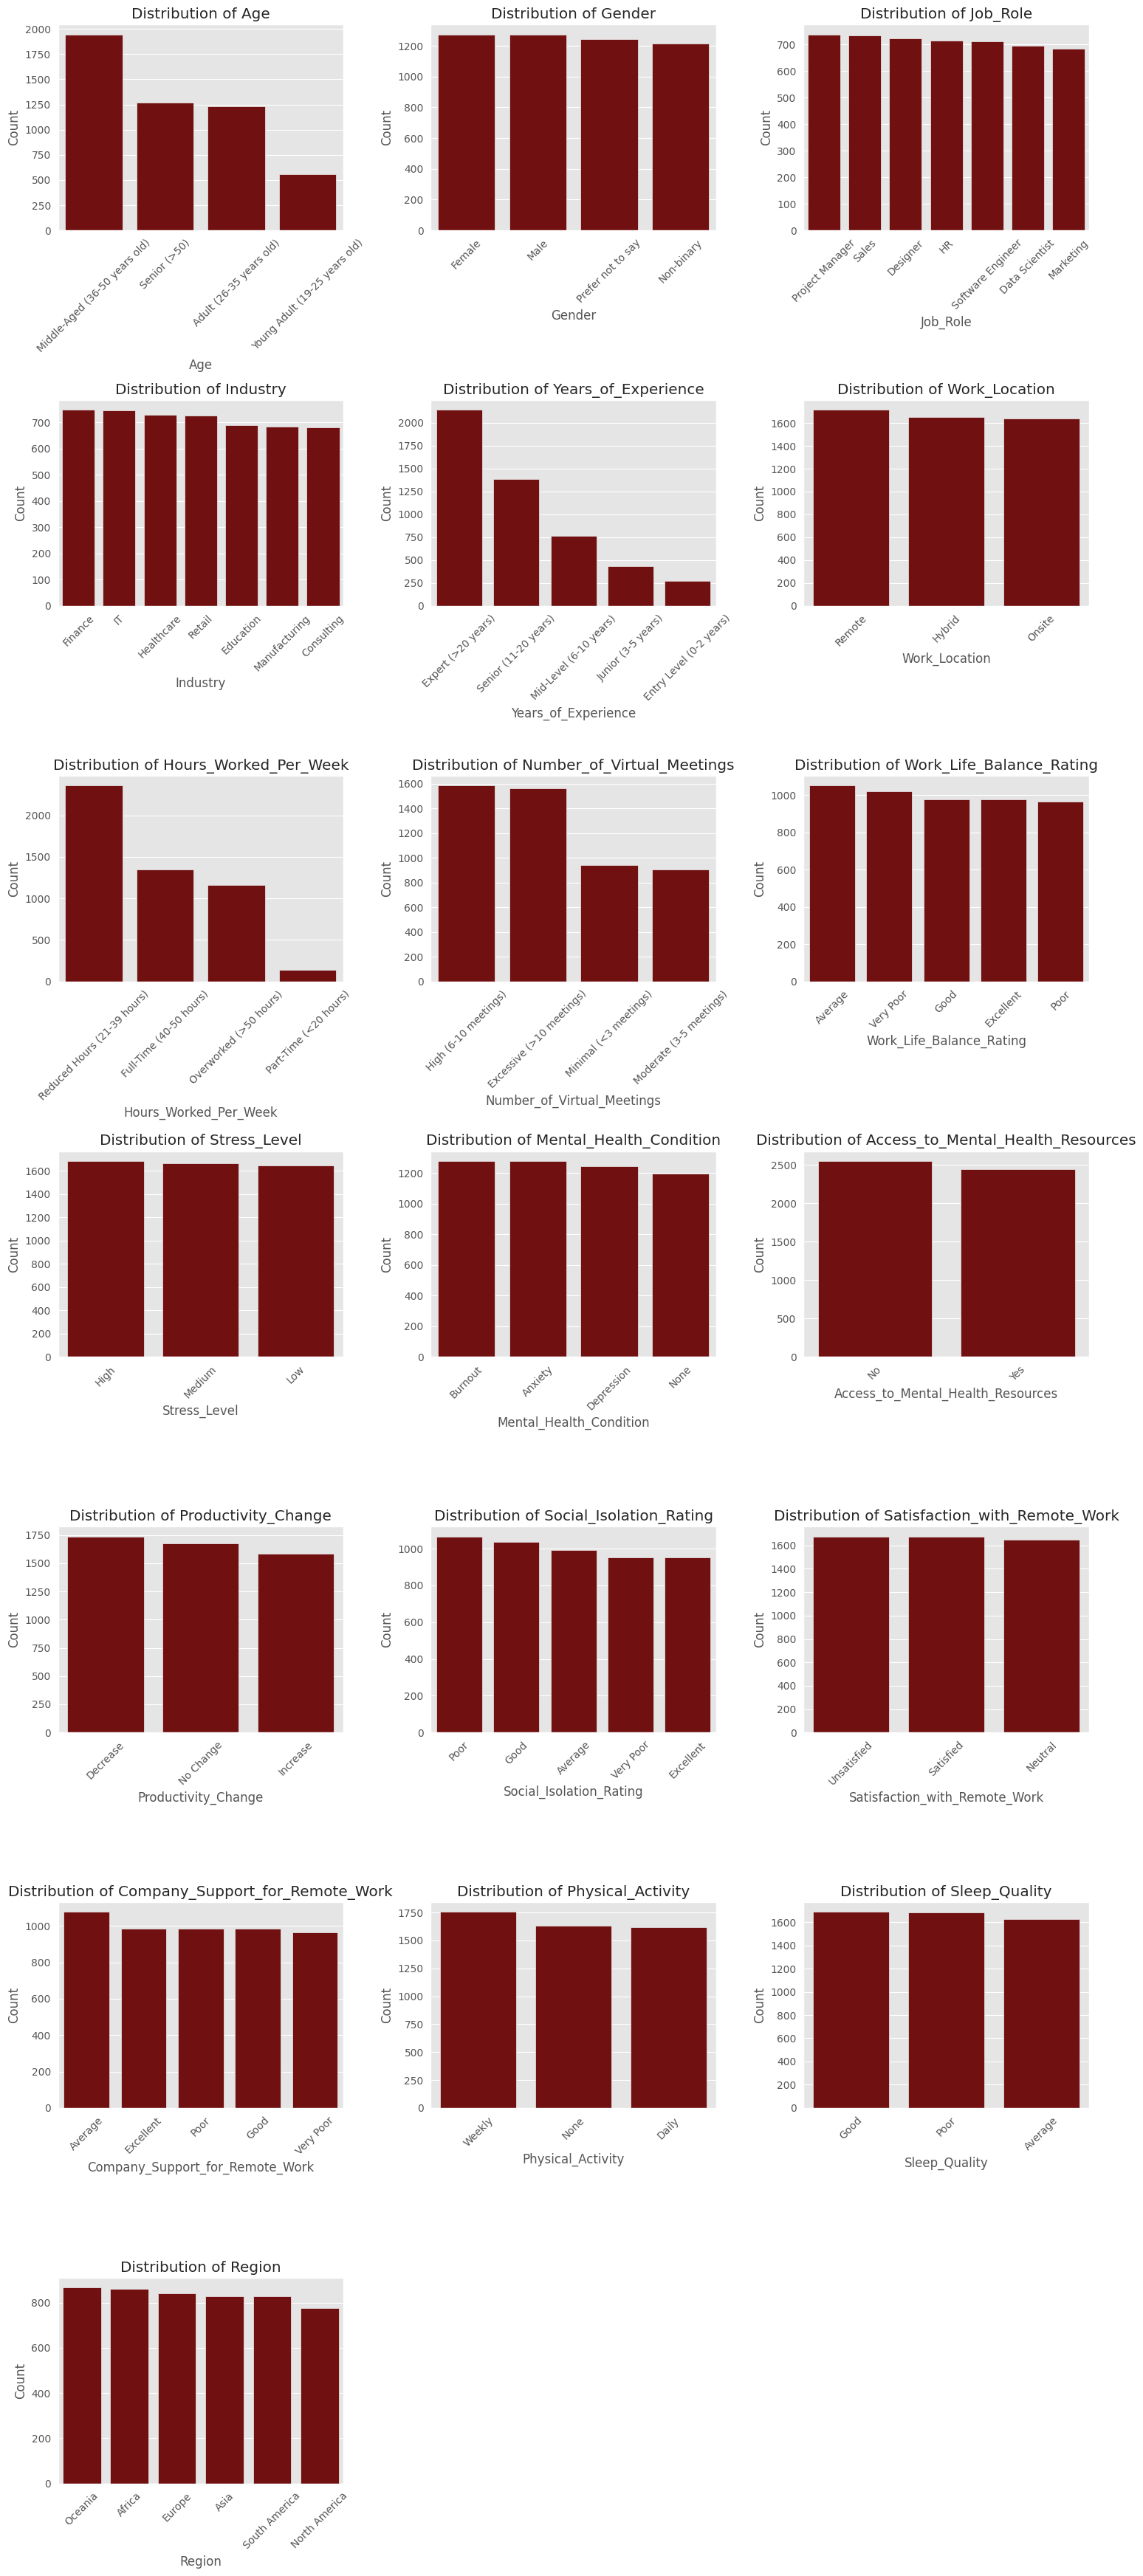

In [ ]:
# histogram for each column
df_pd = df.toPandas()

n_cols = 3
n_rows = len(df_pd.columns) // n_cols + (len(df_pd.columns) % n_cols > 0)

plt.figure(figsize=(15, 5 * n_rows))
plt.style.use('ggplot')

for i, column in enumerate(df_pd.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    value_counts = df_pd[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, color='maroon')

    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

***
### **Association of Columns**
To find whether there is a significant association between the columns, the Chi-Square Test can be used.

In [ ]:
# get columns
columns = df_pd.columns
p_value_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

# make chi-squre function
def chi_square_p(col1, col2):
    contingency_table = pd.crosstab(col1, col2)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return p

# calculate p-value
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            p_value_matrix.loc[col1, col2] = 1.0
        else:
            p_value_matrix.loc[col1, col2] = chi_square_p(df_pd[col1], df_pd[col2])

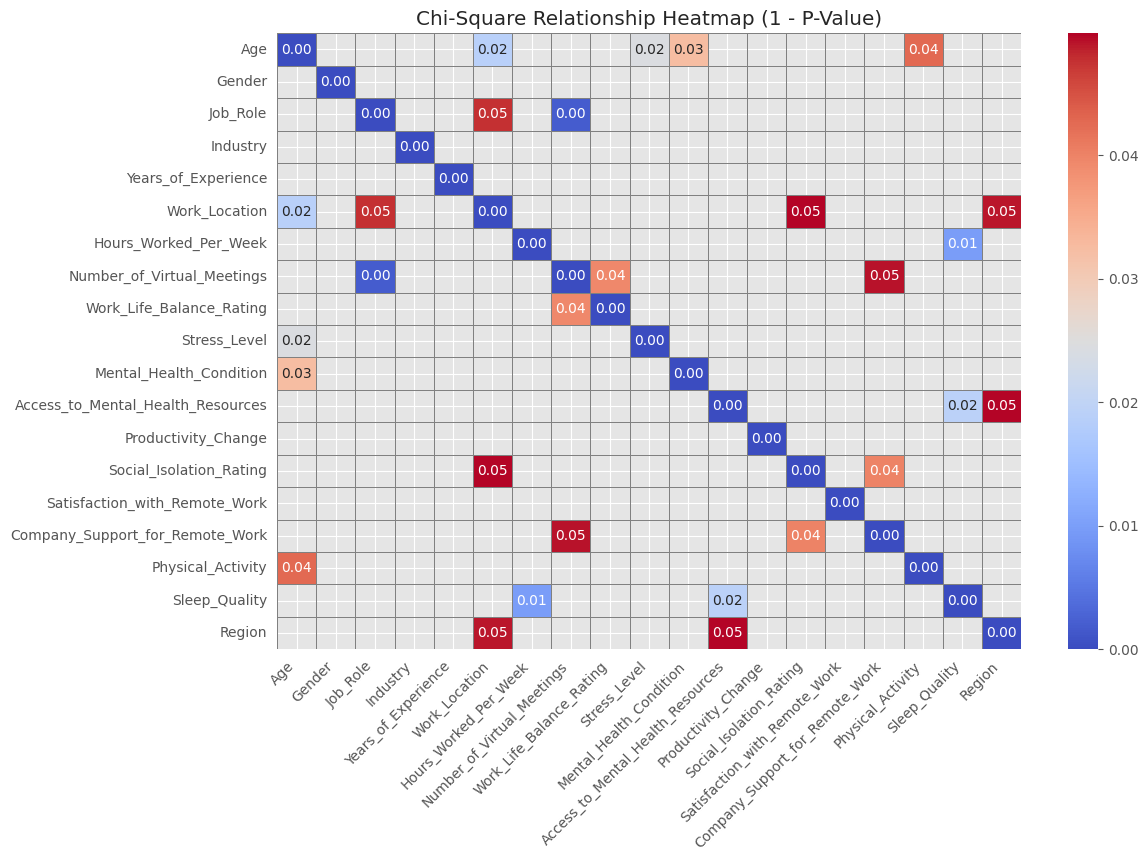

In [ ]:
# create heatmap
heatmap_values = 1 - p_value_matrix.astype(float)

plt.figure(figsize=(12, 8))

# mask if more than 0.05 (no significant association)
mask = heatmap_values > 0.05
sns.heatmap(heatmap_values, annot=True, cmap="coolwarm", fmt=".2f",
            mask=mask, linewidths=0.5, linecolor='gray')

plt.title("Chi-Square Relationship Heatmap (1 - P-Value)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# list associated columns
significant_pairs = np.where((heatmap_values > 0) & (heatmap_values <= 0.05))

rows = heatmap_values.index[significant_pairs[0]]
cols = heatmap_values.columns[significant_pairs[1]]
significant_relationships = [(row, col, heatmap_values.loc[row, col]) for row, col in zip(rows, cols)]
for row, col, value in significant_relationships:
    print(f"{row} - {col}: {value:.4f}")

Age - Work_Location: 0.0189
Age - Stress_Level: 0.0244
Age - Mental_Health_Condition: 0.0324
Age - Physical_Activity: 0.0428
Job_Role - Work_Location: 0.0476
Job_Role - Number_of_Virtual_Meetings: 0.0019
Work_Location - Age: 0.0189
Work_Location - Job_Role: 0.0476
Work_Location - Social_Isolation_Rating: 0.0499
Work_Location - Region: 0.0490
Hours_Worked_Per_Week - Sleep_Quality: 0.0098
Number_of_Virtual_Meetings - Job_Role: 0.0019
Number_of_Virtual_Meetings - Work_Life_Balance_Rating: 0.0395
Number_of_Virtual_Meetings - Company_Support_for_Remote_Work: 0.0492
Work_Life_Balance_Rating - Number_of_Virtual_Meetings: 0.0395
Stress_Level - Age: 0.0244
Mental_Health_Condition - Age: 0.0324
Access_to_Mental_Health_Resources - Sleep_Quality: 0.0191
Access_to_Mental_Health_Resources - Region: 0.0499
Social_Isolation_Rating - Work_Location: 0.0499
Social_Isolation_Rating - Company_Support_for_Remote_Work: 0.0399
Company_Support_for_Remote_Work - Number_of_Virtual_Meetings: 0.0492
Company_Suppor

***
### **Categorising Columns**
The columns are then categorised to help understanding the dataset better. There are 3 types categorisation that I think might help. These are:
* based on context
  * demographic (basic user data)
  * work metric (data related to work)
  * health metric (data related to health)

* based on remote working
  * remote working
  * non-remote working

In [ ]:
# categorise columns

# based on context
demographics_columns = [
                        'Age',
                        'Gender',
                        'Region'
                       ]

work_metrics_columns = [
                        'Job_Role',
                        'Industry',
                        'Years_of_Experience',
                        'Work_Location',
                        'Hours_Worked_Per_Week',
                        'Number_of_Virtual_Meetings',
                        'Work_Life_Balance_Rating',
                        'Productivity_Change',
                        'Satisfaction_with_Remote_Work',
                        'Company_Support_for_Remote_Work'
                       ]

health_metrics_columns = [
                          'Stress_Level',
                          'Mental_Health_Condition',
                          'Access_to_Mental_Health_Resources',
                          'Social_Isolation_Rating',
                          'Physical_Activity', 'Sleep_Quality'
                         ]

context_categories = {
              'Demographics': demographics_columns,
              'Work Metrics': work_metrics_columns,
              'Health Metrics': health_metrics_columns
             }

# based on remote working
remote_working_columns = [
    'Work_Location',
    'Number_of_Virtual_Meetings',
    'Satisfaction_with_Remote_Work',
    'Company_Support_for_Remote_Work',
    'Work_Life_Balance_Rating'
]

non_remote_working_columns = [
    'Age',
    'Gender',
    'Region',
    'Job_Role',
    'Industry',
    'Years_of_Experience',
    'Hours_Worked_Per_Week',
    'Stress_Level',
    'Mental_Health_Condition',
    'Access_to_Mental_Health_Resources',
    'Social_Isolation_Rating',
    'Physical_Activity',
    'Sleep_Quality'
]

categories_remote_work = {
    'Remote Working': remote_working_columns,
    'Not Remote Working': non_remote_working_columns
}

In [ ]:
# based on context
for category, cols in context_categories.items():
    print(f'{category} ({len(cols)}):')
    print(', '.join(cols))
    print()

Demographics (3):
Age, Gender, Region

Work Metrics (10):
Job_Role, Industry, Years_of_Experience, Work_Location, Hours_Worked_Per_Week, Number_of_Virtual_Meetings, Work_Life_Balance_Rating, Productivity_Change, Satisfaction_with_Remote_Work, Company_Support_for_Remote_Work

Health Metrics (6):
Stress_Level, Mental_Health_Condition, Access_to_Mental_Health_Resources, Social_Isolation_Rating, Physical_Activity, Sleep_Quality



In [ ]:
# based on remote working
for category, cols in categories_remote_work.items():
    print(f'{category} ({len(cols)}):')
    print(", ".join(cols))
    print()

Remote Working (5):
Work_Location, Number_of_Virtual_Meetings, Satisfaction_with_Remote_Work, Company_Support_for_Remote_Work, Work_Life_Balance_Rating

Not Remote Working (13):
Age, Gender, Region, Job_Role, Industry, Years_of_Experience, Hours_Worked_Per_Week, Stress_Level, Mental_Health_Condition, Access_to_Mental_Health_Resources, Social_Isolation_Rating, Physical_Activity, Sleep_Quality



In [ ]:
# overview of dataset
df.show(truncate=False)

+-----------------------------+-----------------+-----------------+-------------+-----------------------+-------------+---------------------------+--------------------------+------------------------+------------+-----------------------+---------------------------------+-------------------+-----------------------+-----------------------------+-------------------------------+-----------------+-------------+-------------+
|Age                          |Gender           |Job_Role         |Industry     |Years_of_Experience    |Work_Location|Hours_Worked_Per_Week      |Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Stress_Level|Mental_Health_Condition|Access_to_Mental_Health_Resources|Productivity_Change|Social_Isolation_Rating|Satisfaction_with_Remote_Work|Company_Support_for_Remote_Work|Physical_Activity|Sleep_Quality|Region       |
+-----------------------------+-----------------+-----------------+-------------+-----------------------+-------------+---------------------------+-------

Now that the associated columns are listed and the categories are made, understanding the overview of the dataset would be easier. From this, specific data science questions can be made to achieve the goal of this study.

***
***
##**Data Science Questions**
1. Exploratory Analysis Questions
2. Inferential Analysis Questions
3. Causal Analysis Questions
4. Mechanical Analysis Questions

Since the goal of this study is to improve the work experience as well as the work productivity, the data questions should be focused at understanding the effects of various factors towards various variables. This means that whatever variable is affecting either `Productivity_Change` or `Satisfaction_with_Remote_Work` should be analysed.

<br/>

Based on the previous findings, these are the columns that are associated with each other:

* `Age` - `Work_Location`
* `Age` - `Stress_Level`
* `Age` - `Mental_Health_Condition`
* `Age` - `Physical_Activity`

* `Job_Role` - `Work_Location`
* `Job_Role` - `Number_of_Virtual_Meetings`

* `Work_Location` - `Social_Isolation_Rating`
* `Work_Location` - `Region`

* `Hours_Worked_Per_Week` - `Sleep_Quality`

* `Number_of_Virtual_Meetings` - `Work_Life_Balance_Rating`
* `Number_of_Virtual_Meetings` - `Company_Support_for_Remote_Work`

* `Access_to_Mental_Health_Resources` - `Sleep_Quality`
* `Access_to_Mental_Health_Resources` - `Region`

* `Social_Isolation_Rating` - `Company_Support_for_Remote_Work`

Here, it seems that there is no columns that is associated with either `Productivity_Change` or `Satisfaction_with_Remote_Work`. Since these two columns might affect the employee, such as impacting the employer's perspective of them, the the data might be biased. Because of this, the plausible affecting variables can be analysed instead.

|No.|Question|Variables|Analysis Type|
|-----|-------|------|---|
|1|How does Age influence Work_Location, Stress_Level, Mental_Health_Condition, and Physical_Activity?|`Age`, `Work_Location`, `Stress_Level`, `Mental_Health_Condition`, `Physical_Activity`|Exploratory|
|2|How does Job_Role influence Work_Location and Number_of_Virtual_Meetings in Remote and Hybrid Work Environments?|`Job_Role `, `Work_Location`, `Number_of_Virtual_Meetings`|Exploratory|
|3|How does Work_Location influence Social_Isolation_Rating and Region?|`Work_Location`, `Social_Isolation_Rating`, `Region`|Exploratory|
|4|What is the effect of the Hours_Worked_Per_Week on Sleep_Quality?|`Hours_Worked_Per_Week`, `Sleep_Quality`|Inferential|
|5|Does the Number_of_Virtual_Meetings positively or negatively influence Work_Life_Balance_Rating and the Company_Support_for_Remote_Work?|`Number_of_Virtual_Meetings`, `Work_Life_Balance_Rating`, `Company_Support_for_Remote_Work`|Inferential|
|6|How does Access_to_Mental_Health_Resources influence Sleep_Quality and Region?|`Access_to_Mental_Health_Resources`, `Sleep_Quality`, `Region`|Causal|
|7|How does the level of Company_Support_for_Remote_Work influence the Social_Isolation_Rating?|`Social_Isolation_Rating`, `Company_Support_for_Remote_Work`|Causal|
|8|How does the Work_Location influence the Social_Isolation_Rating. What factors contribute to this relationship?|`Work_Location`, `Social_Isolation_Rating`|Mechanical|

###**1. How does Age influence Work_Location, Stress_Level, Mental_Health_Condition, and Physical_Activity among employees (Exploratory Analysis)**
> This question explores the relationship between `Age` and other factors such as `Work_Location`, `Stress_Level`, `Mental_Health_Condition`, and `Physical_Activity`. The goal is to understand if there are patterns or trends in how age groups experience or respond to these variables.

Feature:
1. `Age`

Target:
1. `Mental_Health_Condition`
2. `Work_Location`
3. `Stress_Level`
4. `Physical_Activity`

Steps:
1. feature selection
2. create barplots

In [ ]:
# feature selection
q1 = df.select(
    'Age',
    'Work_Location',
    'Stress_Level',
    'Mental_Health_Condition',
    'Physical_Activity'
)
q1.show(5, truncate=False)

+-----------------------------+-------------+------------+-----------------------+-----------------+
|Age                          |Work_Location|Stress_Level|Mental_Health_Condition|Physical_Activity|
+-----------------------------+-------------+------------+-----------------------+-----------------+
|Adult (26-35 years old)      |Hybrid       |Medium      |Depression             |Weekly           |
|Middle-Aged (36-50 years old)|Remote       |Medium      |Anxiety                |Weekly           |
|Senior (>50)                 |Hybrid       |Medium      |Anxiety                |None             |
|Adult (26-35 years old)      |Onsite       |High        |Depression             |None             |
|Middle-Aged (36-50 years old)|Onsite       |High        |None                   |Weekly           |
+-----------------------------+-------------+------------+-----------------------+-----------------+
only showing top 5 rows



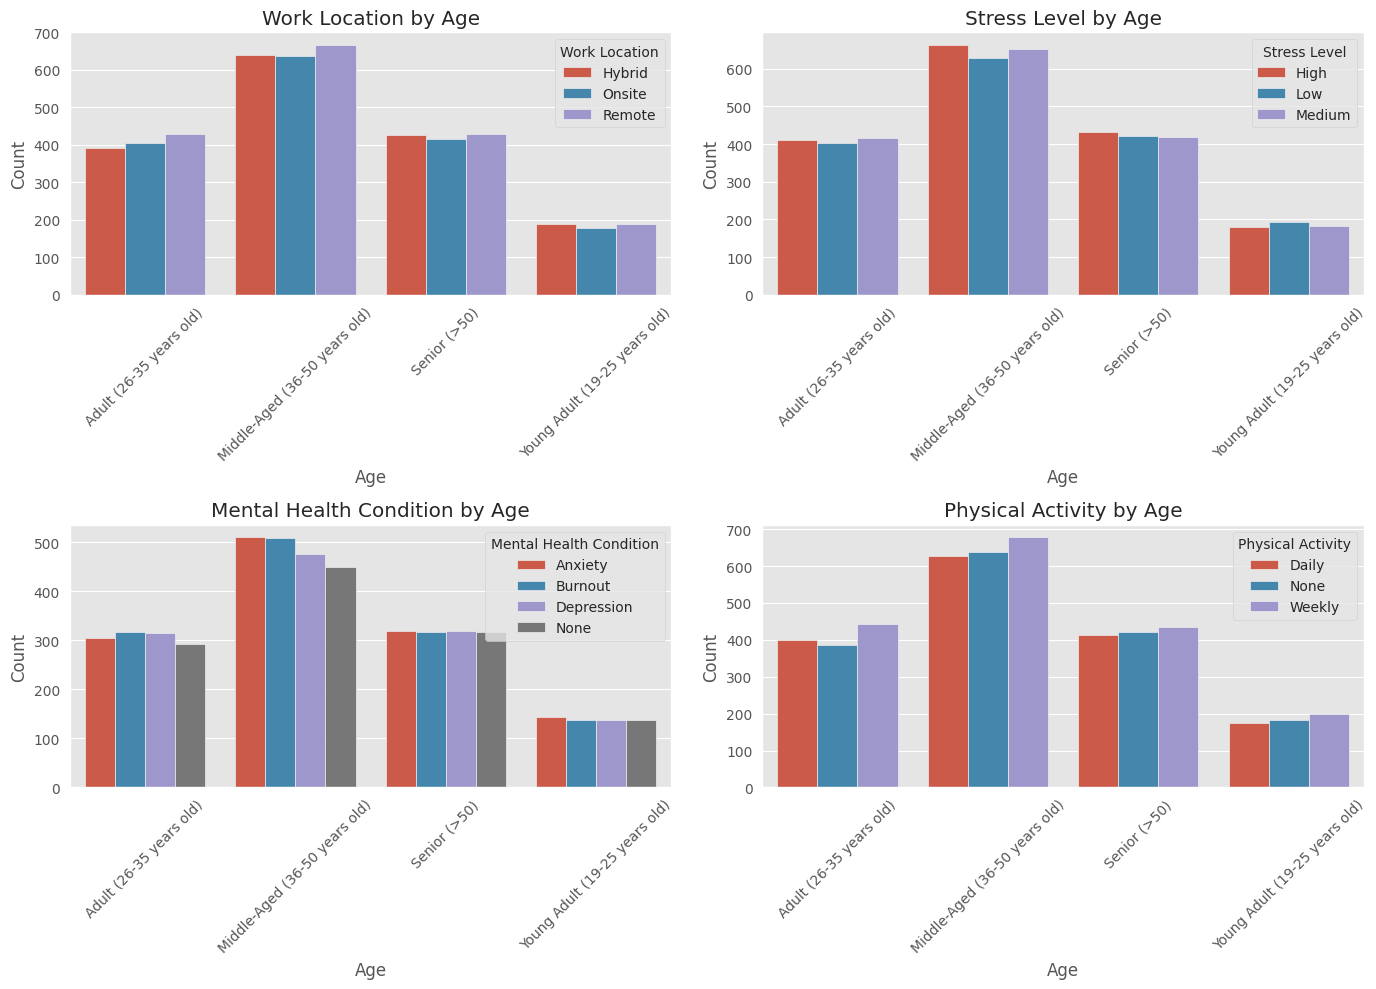

In [ ]:
# create barplots
q1_pd = q1.toPandas()
q1_work_location = q1_pd.groupby(['Age', 'Work_Location']).size().reset_index(name='Count')
q1_stress = q1_pd.groupby(['Age', 'Stress_Level']).size().reset_index(name='Count')
q1_mental_health = q1_pd.groupby(['Age', 'Mental_Health_Condition']).size().reset_index(name='Count')
q1_physical_activity = q1_pd.groupby(['Age', 'Physical_Activity']).size().reset_index(name='Count')
plt.figure(figsize=(14, 10))

# Work_Location
plt.subplot(2, 2, 1)
sns.barplot(data=q1_work_location, x='Age', y='Count', hue='Work_Location')
plt.title('Work Location by Age')
plt.xticks( rotation=45)
plt.legend(title='Work Location')

# Stress_Level
plt.subplot(2, 2, 2)
sns.barplot(data=q1_stress, x='Age', y='Count', hue='Stress_Level')
plt.title('Stress Level by Age')
plt.xticks(rotation=45)
plt.legend(title='Stress Level')

# Mental_Health_Condition
plt.subplot(2, 2, 3)
sns.barplot(data=q1_mental_health, x='Age', y='Count', hue='Mental_Health_Condition')
plt.title('Mental Health Condition by Age')
plt.xticks(rotation=45)
plt.legend(title='Mental Health Condition')

# Physical_Activity
plt.subplot(2, 2, 4)
sns.barplot(data=q1_physical_activity, x='Age', y='Count', hue='Physical_Activity')
plt.title('Physical Activity by Age')
plt.xticks(rotation=45)
plt.legend(title='Physical Activity')

plt.tight_layout()
plt.show()

Based on these barplots, most of the employees work remotely. Next, the stress levels for the employees shifts towards the high level. For the mental haelth condition, while most of the age groups have similar distribution, most middle-aged employees suffered from anxiety and burnout. Finally, for the physical activity, and most of the employees did physical acitivty on a weekly basis.

###**2. How does Job_Role influence Work_Location and Number_of_Virtual_Meetings? (Exploratory Analysis)**
> This question is to examines how the `Number_of_Virtual_Meetings` varies based on `Job_Role`, which could provide insights into communication demands for different professions.

Feature:
1. `Job_Role`

Target:
1. `Number_of_Virtual_Meetings`

Steps:
1. feature selection
2. create barplot

In [ ]:
# feature selection
q2 = df.select(
    'Job_Role',
    'Number_of_Virtual_Meetings'
)
q2.show(5, truncate=False)

+-----------------+--------------------------+
|Job_Role         |Number_of_Virtual_Meetings|
+-----------------+--------------------------+
|HR               |High (6-10 meetings)      |
|Data Scientist   |Moderate (3-5 meetings)   |
|Software Engineer|Excessive (>10 meetings)  |
|Software Engineer|High (6-10 meetings)      |
|Sales            |Excessive (>10 meetings)  |
+-----------------+--------------------------+
only showing top 5 rows



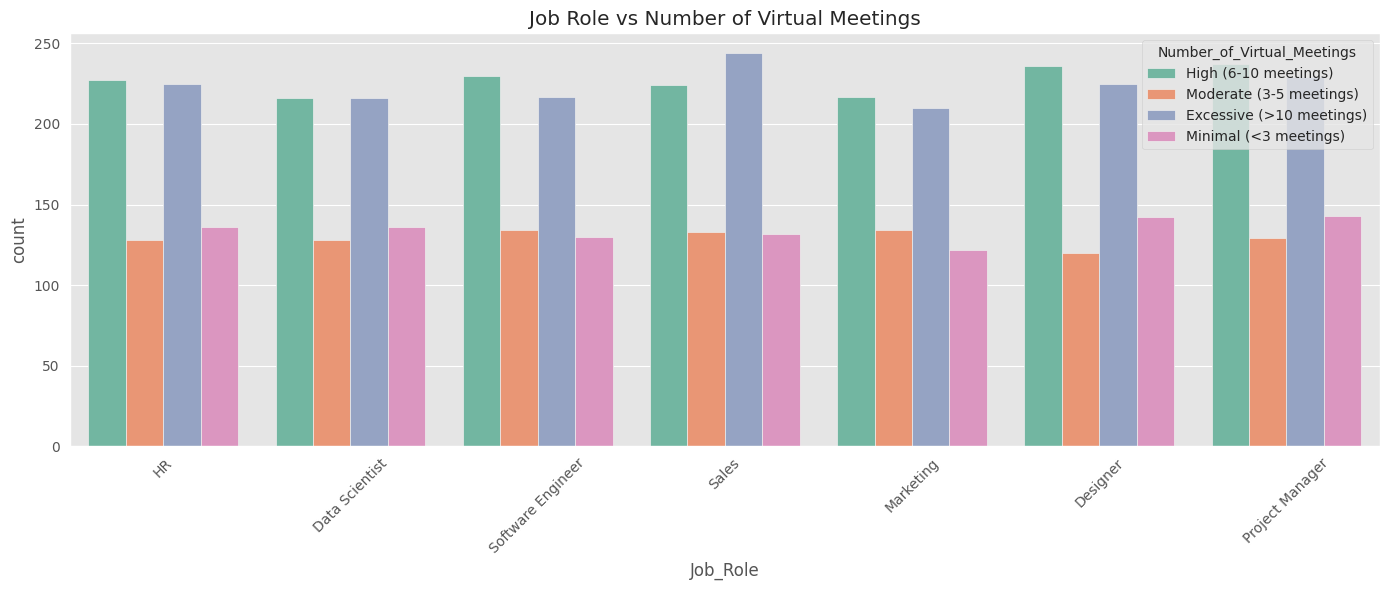

In [ ]:
# create barplot
q2_pd = q2.toPandas()
plt.figure(figsize=(14, 6))

sns.countplot(data=q2_pd, x='Job_Role', hue='Number_of_Virtual_Meetings', palette='Set2')
plt.title('Job Role vs Number of Virtual Meetings')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on this graph, the number of virtual meetings are noticably very high for all of the job roles. Around half of the employees experience moderate to minial number of meetings.

###**3. How does Work_Location influence Social_Isolation_Rating and Region?? (Exploratory Analysis)**
> This question is to uncover if the `Work_Location` has any impact on `Social_Isolation_Rating` and their `Region`.

Feature:
1. `Work_Location`

Target:
1. `Social_Isolation_Rating`
2. `Region `

Steps:
1. feature selection
2. create barplots

In [ ]:
# feature selection
q3 = df.select(
    'Work_Location',
    'Social_Isolation_Rating',
    'Region'
)
q3.show(5, truncate=False)

+-------------+-----------------------+-------------+
|Work_Location|Social_Isolation_Rating|Region       |
+-------------+-----------------------+-------------+
|Hybrid       |Very Poor              |Europe       |
|Remote       |Average                |Asia         |
|Hybrid       |Good                   |North America|
|Onsite       |Average                |Europe       |
|Onsite       |Average                |North America|
+-------------+-----------------------+-------------+
only showing top 5 rows



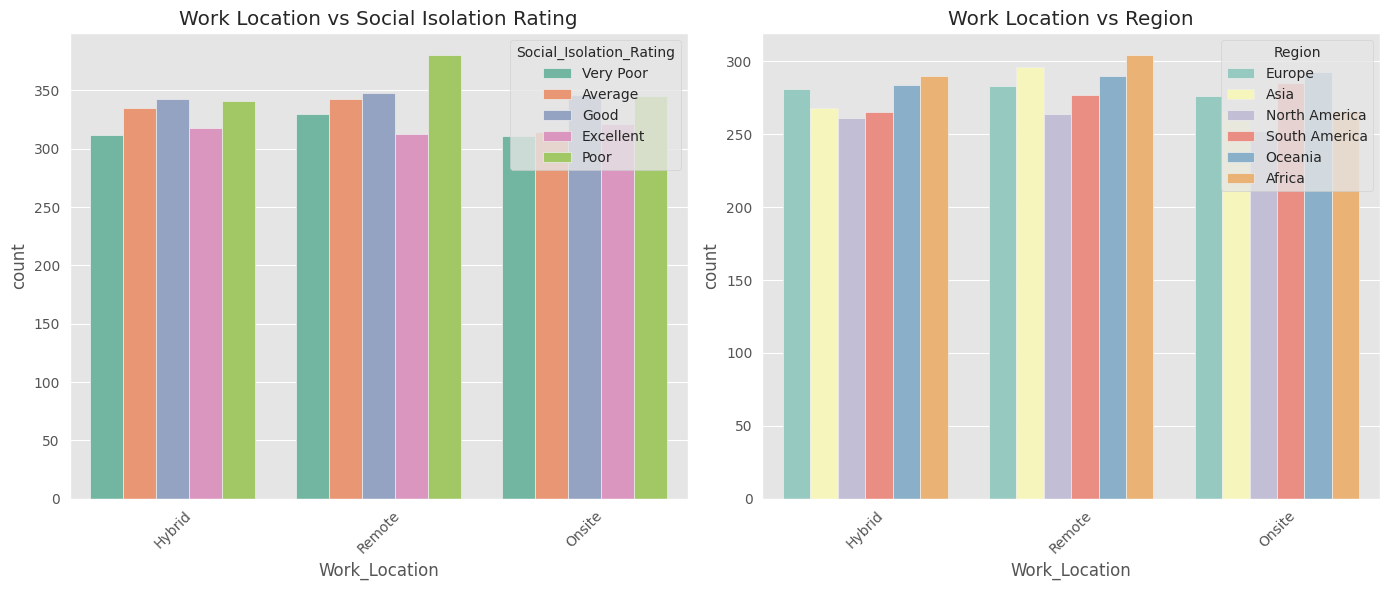

In [ ]:
# create barplots
q3_pd = q3.toPandas()
plt.figure(figsize=(14, 6))

# Work_Location
plt.subplot(1, 2, 1)
sns.countplot(data=q3_pd, x='Work_Location', hue='Social_Isolation_Rating', palette='Set2')
plt.title('Work Location vs Social Isolation Rating')
plt.xticks(rotation=45)

# Number_of_Virtual_Meetings
plt.subplot(1, 2, 2)
sns.countplot(data=q3_pd, x='Work_Location', hue='Region', palette='Set3')
plt.title('Work Location vs Region')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on the barplots, the social isolation rating for remote work has the highest number of very poor rating, followed by onsite and hybrid. However, remote work also has the highest number of good rating, followed by onsite and hybrid. Other number of ratings are similar overall.  

On the other hand, Africa is the region that the highest number of remote work, followed by Asia and Oceania. Meanwhile, Ocenia has the highest number of remote work, followed by South America and Europe.

####**4. What is the effect of the Hours_Worked_Per_Week on Sleep_Quality among employees? (Inferential Analysis)**
>  This question is to make sure that less `Hours_Worked_Per_Week` means better `Sleep_Quality`.

Feature:
1. `Hours_Worked_Per_Week`

Target:
1. `Sleep_Quality`

Steps:
1. feature selection
2. create barplots

In [ ]:
# feature selection
q4 = df.select(
    'Hours_Worked_Per_Week',
    'Sleep_Quality'
)
q4.show(5, truncate=False)

+---------------------------+-------------+
|Hours_Worked_Per_Week      |Sleep_Quality|
+---------------------------+-------------+
|Full-Time (40-50 hours)    |Good         |
|Overworked (>50 hours)     |Good         |
|Full-Time (40-50 hours)    |Poor         |
|Reduced Hours (21-39 hours)|Poor         |
|Reduced Hours (21-39 hours)|Average      |
+---------------------------+-------------+
only showing top 5 rows



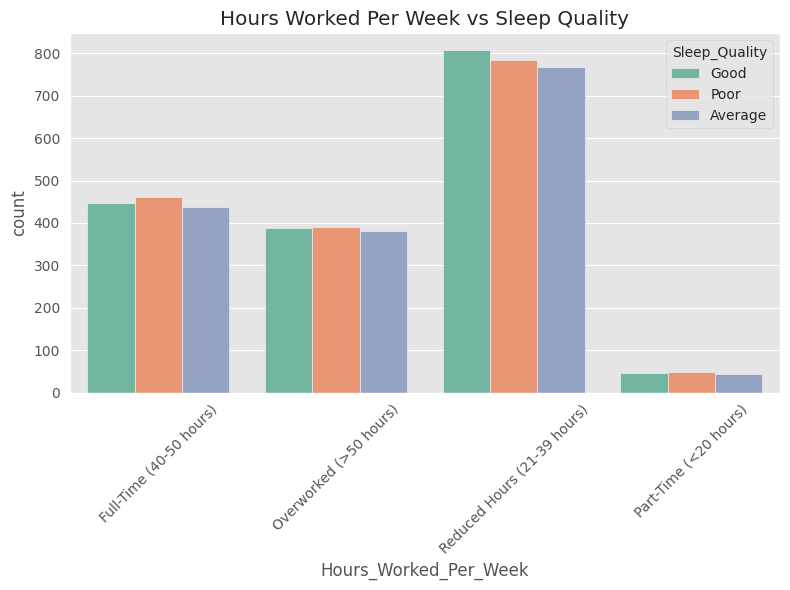

In [ ]:
# create barplots
q4_pd = q4.toPandas()
plt.figure(figsize=(8, 6))

sns.countplot(data=q4_pd, x='Hours_Worked_Per_Week', hue='Sleep_Quality', palette='Set2')
plt.title('Hours Worked Per Week vs Sleep Quality')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on this barplot, expectedly, the lowest hours per week provides the highest number of good quality sleep.

###**5. Does the Number_of_Virtual_Meetings positively or negatively influence Work_Life_Balance_Rating and the Company_Support_for_Remote_Work?(Inferential Analysis)**
> This question is to determine whether an increase in `Number_of_Virtual_Meetings` negatively impacts `Work_Life_Balance_Rating` and the `Company_Support_for_Remote_Work`.

Feature:
1. `Number_of_Virtual_Meetings`

Target:
1. `Work_Life_Balance_Rating`
2. `Company_Support_for_Remote_Work`

Steps:
1. feature selection
2. create barplots

In [ ]:
# feature selection
q5 = df.select(
    'Number_of_Virtual_Meetings',
    'Work_Life_Balance_Rating',
    'Company_Support_for_Remote_Work'
)
q5.show(5, truncate=False)

+--------------------------+------------------------+-------------------------------+
|Number_of_Virtual_Meetings|Work_Life_Balance_Rating|Company_Support_for_Remote_Work|
+--------------------------+------------------------+-------------------------------+
|High (6-10 meetings)      |Poor                    |Very Poor                      |
|Moderate (3-5 meetings)   |Very Poor               |Poor                           |
|Excessive (>10 meetings)  |Excellent               |Excellent                      |
|High (6-10 meetings)      |Good                    |Average                        |
|Excessive (>10 meetings)  |Poor                    |Average                        |
+--------------------------+------------------------+-------------------------------+
only showing top 5 rows



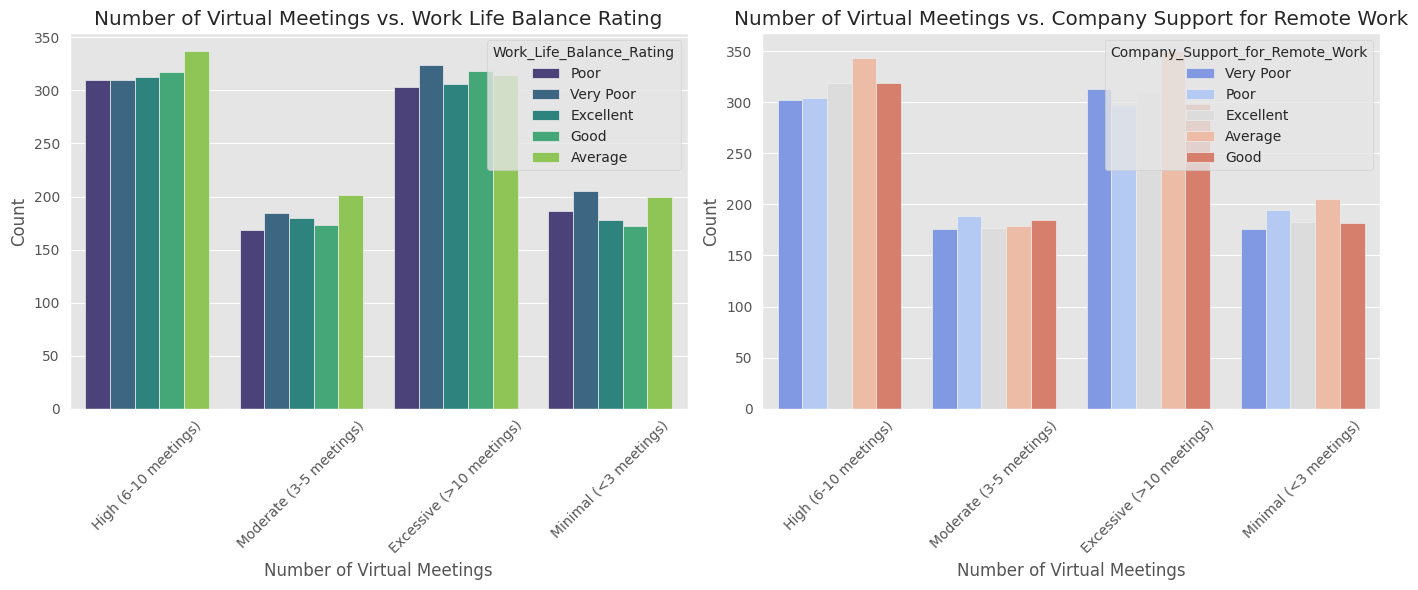

In [ ]:
# create barplots
q5_pd = q5.toPandas()
plt.figure(figsize=(14, 6))

# Work_Life_Balance_Rating
plt.subplot(1, 2, 1)
sns.countplot(x='Number_of_Virtual_Meetings', hue='Work_Life_Balance_Rating', data=q5_pd, palette='viridis')
plt.title('Number of Virtual Meetings vs. Work Life Balance Rating')
plt.xlabel('Number of Virtual Meetings')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Company_Support_for_Remote_Work
plt.subplot(1, 2, 2)
sns.countplot(x='Number_of_Virtual_Meetings', hue='Company_Support_for_Remote_Work', data=q5_pd, palette='coolwarm')
plt.title('Number of Virtual Meetings vs. Company Support for Remote Work')
plt.xlabel('Number of Virtual Meetings')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on these barplots, high number of virtual meetings corresponds to average work life balance. Unexpectedly, the meetings did not have a grave impact on the work life balance. On the other hand, also unexpectedly, high number of virtual meetings means to receive average or greater company support for remote work.

###**6. 	How does Access_to_Mental_Health_Resources influence Sleep_Quality and Region? (Causal Analysis)**
> This question is to understand whether improved `Access_to_Mental_Health_Resources` leads to better `Sleep_Quality` and if `Region` contribute to the effectiveness of mental health support.

Feature:
1. `Access_to_Mental_Health_Resources`

Target:
1. `Sleep_Quality`
2. `Region`

Steps:
1. feature selection
2.

In [ ]:
# feature selection
q6 = df.select(
    'Access_to_Mental_Health_Resources',
    'Sleep_Quality',
    'Region'
)
q6.show(5, truncate=False)

+---------------------------------+-------------+-------------+
|Access_to_Mental_Health_Resources|Sleep_Quality|Region       |
+---------------------------------+-------------+-------------+
|No                               |Good         |Europe       |
|No                               |Good         |Asia         |
|No                               |Poor         |North America|
|Yes                              |Poor         |Europe       |
|Yes                              |Average      |North America|
+---------------------------------+-------------+-------------+
only showing top 5 rows



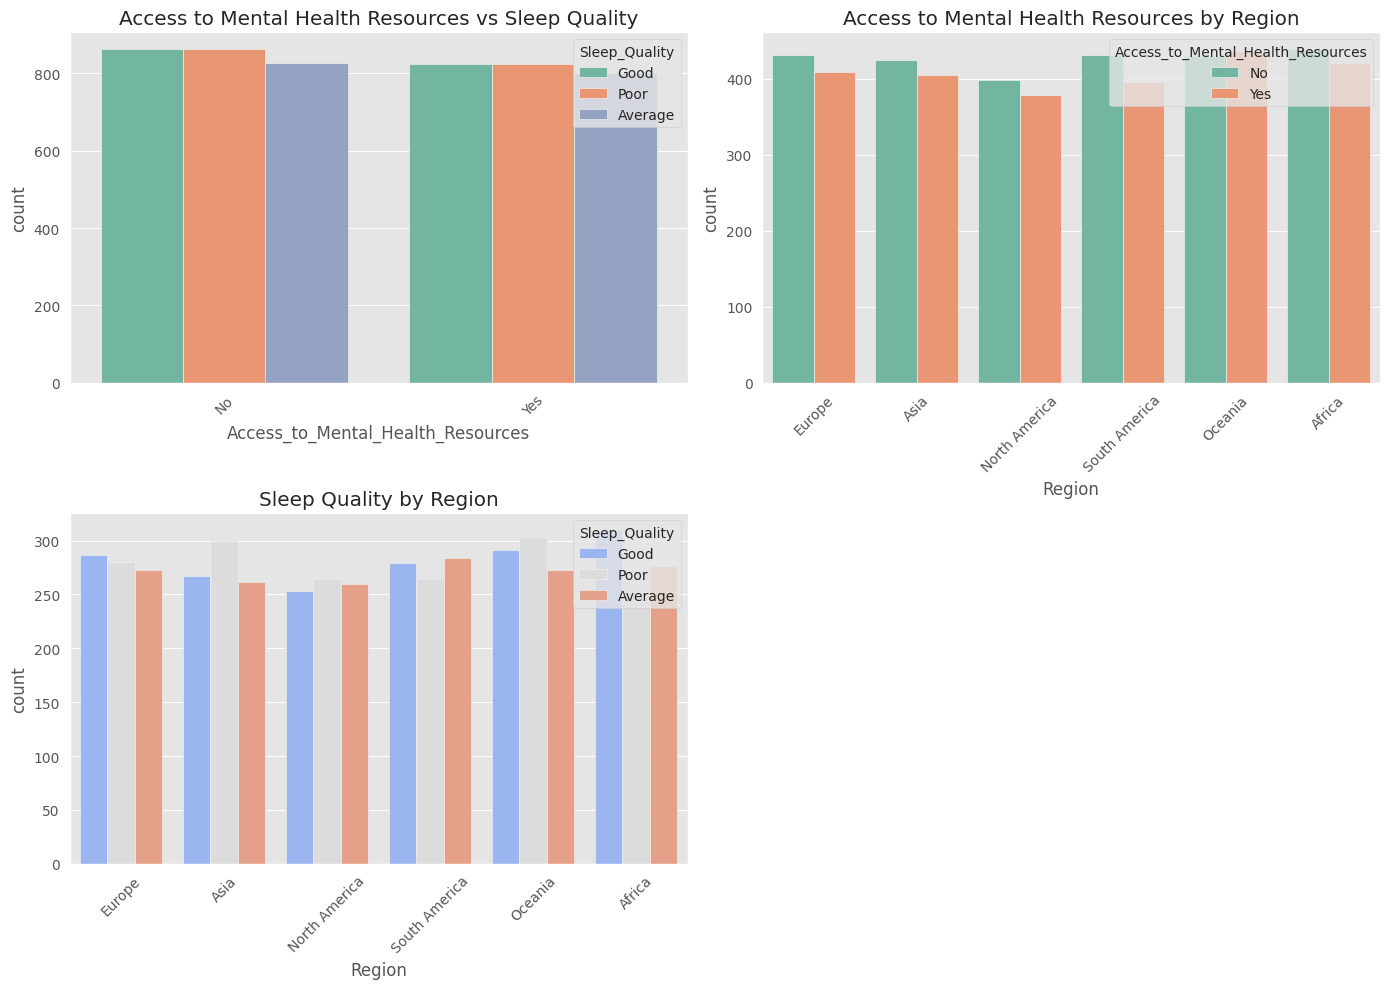

In [ ]:
# create barplots
q6_pd = q6.toPandas()
plt.figure(figsize=(14, 10))

# Access_to_Mental_Health_Resources
plt.subplot(2, 2, 1)
sns.countplot(x='Access_to_Mental_Health_Resources', hue='Sleep_Quality', data=q6_pd, palette='Set2')
plt.title('Access to Mental Health Resources vs Sleep Quality')
plt.xticks(rotation=45)

# Access_to_Mental_Health_Resources
plt.subplot(2, 2, 2)
sns.countplot(x='Region', hue='Access_to_Mental_Health_Resources', data=q6_pd, palette='Set2')
plt.title('Access to Mental Health Resources by Region')
plt.xticks(rotation=45)

# Sleep_Quality
plt.subplot(2, 2, 3)
sns.countplot(x='Region', hue='Sleep_Quality', data=q6_pd, palette='coolwarm')
plt.title('Sleep Quality by Region')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on these barplots, access to mental health resources has little to no leverage to the sleep, despite having a significant association.

Region-wise, having no access to mental health resources, Asia seems to have the highest number of poor sleep quality. However, Africa seems to have the highest number of good sleep quality, despite not having access to mental health resources. Interesetingly, Oceania have a high number of poor sleep quality despite having almost equal amount of access to mental health resources.

###**7. How does the level of Company_Support_for_Remote_Work influence the Social_Isolation_Rating?  (Causal Analysis)**
> This question is to understand how effective `Company_Support_for_Remote_Work` are in reducing `Social_Isolation_Rating`.

Feature:
1. `Company_Support_for_Remote_Work`

Target:
1. `Social_Isolation_Rating`

Steps:
1. feature selection
2. create barplots

In [ ]:
# feature selection
q7 = df.select(
    'Company_Support_for_Remote_Work',
    'Social_Isolation_Rating'
)
q7.show(5, truncate=False)

+-------------------------------+-----------------------+
|Company_Support_for_Remote_Work|Social_Isolation_Rating|
+-------------------------------+-----------------------+
|Very Poor                      |Very Poor              |
|Poor                           |Average                |
|Excellent                      |Good                   |
|Average                        |Average                |
|Average                        |Average                |
+-------------------------------+-----------------------+
only showing top 5 rows



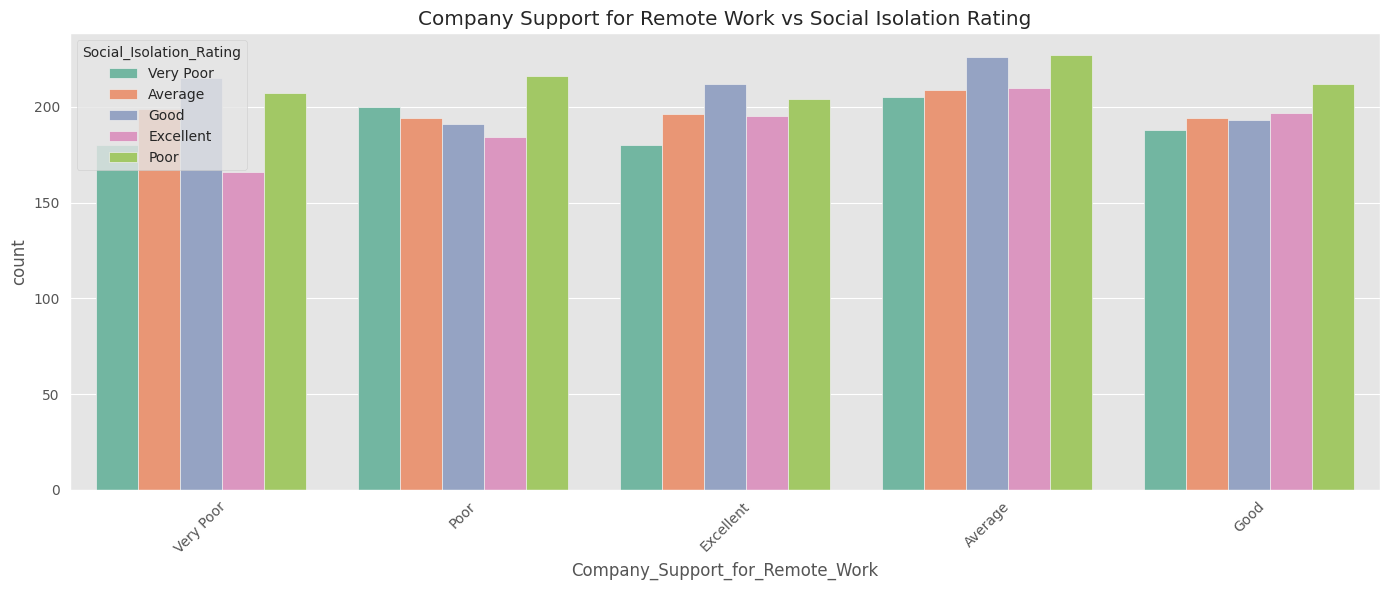

In [ ]:
# create barplots
q7_pd = q7.toPandas()
plt.figure(figsize=(14, 6))

sns.countplot(data=q7_pd, x='Company_Support_for_Remote_Work', hue='Social_Isolation_Rating', palette='Set2')
plt.title('Company Support for Remote Work vs Social Isolation Rating')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on these barplots, excellent support from the company for remote mostly means good social isolation rating. The same goes for the very poor support.

On the other hand, excellent isolation rating mostly means average company support for remote work, while very poor rating mostly means either very poor or excellent support from the company.

Confusing as this is, one finding that can be taken of is that poor support from the company for remote work mostly means poor social isolation rating. However, this can be due to a coincidence.

From all this, it can be inferred that, despite having significant association, greater company support for remote work does not necessarily mean better social isolation rating.

###**8.How does the Work_Location influence the Social_Isolation_Rating. What factors contribute to this relationship? (Mechanical Analysis)**
> This question is to explore how `Work_Location` affects the `Social_Isolation_Rating`

Feature:
1. `Work_Location`

Target:
1. `Social_Isolation_Rating`

Steps:
1. feature selection
2. create barplots

In [ ]:
# feature selection
q8 = df.select(
    'Work_Location',
    'Social_Isolation_Rating'
)
q8.show(5, truncate=False)

+-------------+-----------------------+
|Work_Location|Social_Isolation_Rating|
+-------------+-----------------------+
|Hybrid       |Very Poor              |
|Remote       |Average                |
|Hybrid       |Good                   |
|Onsite       |Average                |
|Onsite       |Average                |
+-------------+-----------------------+
only showing top 5 rows



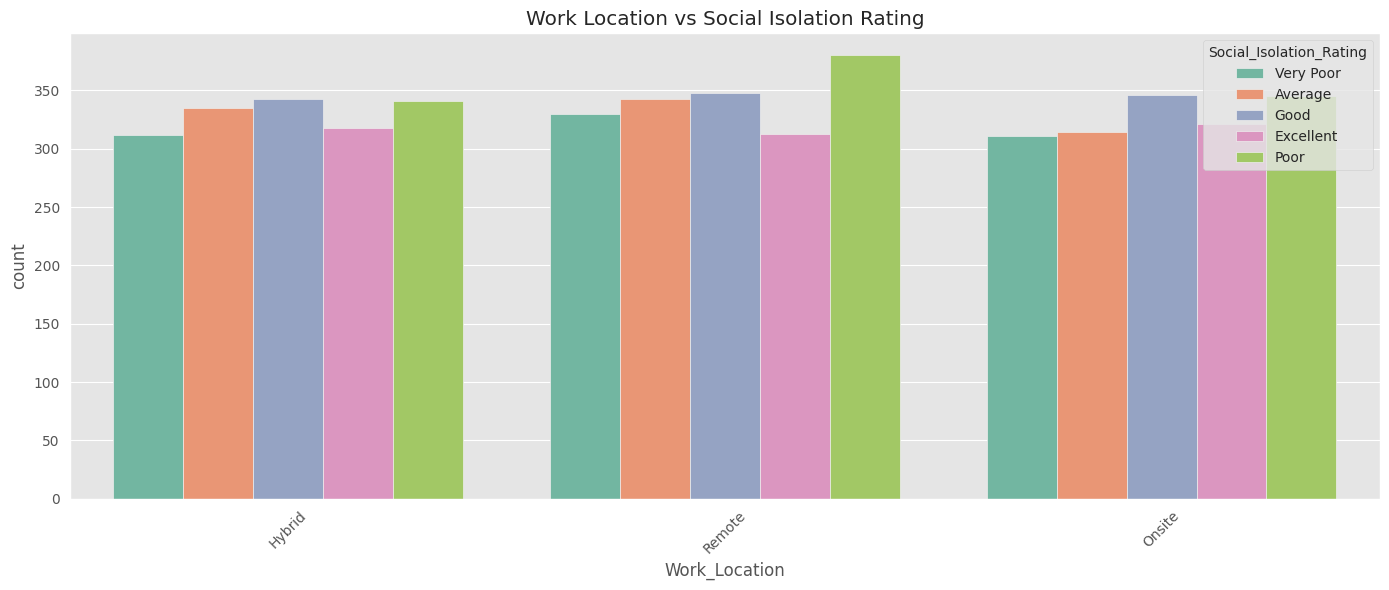

In [ ]:
# create barplots
q8_pd = q8.toPandas()
plt.figure(figsize=(14, 6))

sns.countplot(data=q8_pd, x='Work_Location', hue='Social_Isolation_Rating', palette='Set2')
plt.title('Work Location vs Social Isolation Rating')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on these barplots, remote work shift towards bad isolation rating. Meanwhile, suprisingly, hybrid has the highest number of excellent social rating.

***
***
##**Conclusion**

While some connections are inconclusive, there are a few variables that appeared to have an effect towards another variable. From the study, we now know that all job roles mostly have high number of virtual meetings. These meetings did not have a great impact towards the work-life balance. Moreover, these meetings also means average or above company support for remote work. Expectedly, fewer working hours corresponds to better sleep quality. Access to mental health resources, on the other hand, has an inconclusive effect, may be non, to sleep quality.